# Modeling Influenza A PR8 (H1N1) in the lungs of mice

This notebook plots the results of parameter optimization using a classical estimation approach and our Integrative Parameter Estimation (IPE) approach.

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

import seaborn as sns

In [2]:
palette = sns.color_palette('viridis', n_colors=8)
palette

[(0.281412, 0.155834, 0.469201),
 (0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476),
 (0.709898, 0.868751, 0.169257)]

In [3]:
palette_2 = sns.color_palette('rocket', n_colors=3)
palette_2

[(0.38092887, 0.12061482, 0.32506528),
 (0.7965014, 0.10506637, 0.31063031),
 (0.95922872, 0.53307513, 0.3748895)]

## Lung Target Cell Model
Define the target cell model with T cell compartment

\begin{align}
\dot U &= - \beta U V \\
\dot I &= \beta U V - \delta_I T I \\
\dot V &= p I - c V \\
\dot T &= \delta_T T_0 + r T V - \delta_T T
\end{align}

In [4]:
def lungModel(Y, t, bet, del_I, p, c, r, del_T, T0):
    U, I, V, T = Y
    
    U = max(0,U)
    I = max(0,I)
    V = max(0,V)
    T = max(0,T)

    dU = -bet*U*V
    dI = bet*U*V - del_I*T*I
    dV = p*I - c*V
    dT = r*T*V + del_T*(T0 - T)
    
    return [dU, dI, dV, dT]

In [5]:
parNames=['$V_0$', '$\\beta$', '$\\delta_I$', '$p$', '$c$', '$r$', '$\\delta_T$', 'RSS']

Run all parameter set simulations

In [6]:
def simulations(dfParams, Y0, t, simNum):
    U = []
    I = []
    V = []
    T = []
    
    for i in range(simNum):
        bet = dfParams['$\\beta$'][i]
        del_I = dfParams['$\\delta_I$'][i]
        p = dfParams['$p$'][i]
        c = dfParams['$c$'][i]
        r = dfParams['$r$'][i]
        del_T = dfParams['$\\delta_T$'][i]
        U0, I0, V0, T0 = Y0
        V0 = dfParams['$V_0$'][i]
        Y0 = [U0, I0, V0, T0]
    
        sol = odeint(lungModel, Y0, t, args=(bet, del_I, p, c, r, del_T, T0))
        U.append(sol[:,0])
        I.append(sol[:,1])
        V.append(sol[:,2])
        T.append(sol[:,3])

    return [U, I, V, T]

## Estimating parameters (all parameters free)

In [7]:
dfViralData = pd.read_csv('influenza/viralLoad.csv')

In [8]:
dfViralData.head(4)

,Days,Virus
0,2,448592.338
1,2,1126813.007
2,2,4262158.829
3,2,1126813.007


### Quantitative estimation

In [9]:
dfParams = pd.read_csv('influenza/bestPars_quant.dat', sep=' ', names=parNames)

In [10]:
dfParams.head()

,$V_0$,$\beta$,$\delta_I$,$p$,$c$,$r$,$\delta_T$,RSS
0,21247.0,1.760600e-07,1.899300e-06,12.1680,2.6602,7.134900e-07,0.313130,12.3180
1,16179.0,3.310100e-07,1.487000e-06,5.7846,2.0530,3.906600e-07,0.399800,12.5180
2,11546.0,3.824400e-07,3.468100e-06,7.6742,2.6548,3.064800e-07,0.265310,8.4698
3,3354.9,7.330900e-07,3.919500e-06,4.5595,1.7957,1.095800e-08,10.937000,6.0416
4,1928.4,7.540700e-06,6.377200e-07,0.3418,1.6825,4.436400e-07,0.011266,6.2925


In [11]:
U0 = 1e7
I0 = 0
V0 = 0
T0 = 1e6
Y0 = [U0, I0, V0, T0]

t = np.linspace(0, 25, 561)

simNumber = dfParams.shape[0]

U_Qt, I_Qt, V_Qt, T_Qt = simulations(dfParams, Y0, t, simNumber)

In [12]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
VQt_2D = np.array(V_Qt)
TQt_2D = np.array(T_Qt)
median_VQt = np.median(VQt_2D, axis=0)
confidence_VQt = np.percentile(VQt_2D, [2.5, 97.5], axis=0)
median_TQt = np.median(TQt_2D, axis=0)
confidence_TQt = np.percentile(TQt_2D, [2.5, 97.5], axis=0)
# mean_VQt = np.mean(VQt_2D, axis=0)
# std_VQt = np.std(VQt_2D, axis=0)

In [13]:
dfParams_quant = dfParams.drop(columns=['RSS']).melt(var_name='Parameters', value_name='Values')

### Qualitative T cell level

In [14]:
dfTcellQual = pd.read_csv('influenza/qualTcell.csv')

Tmax = 1e7
T0 = 1e6
dfTcellQual['Tmin'] = dfTcellQual['Tmin']*(Tmax-T0) + T0
dfTcellQual['Tmax'] = dfTcellQual['Tmax']*(Tmax-T0) + T0

In [15]:
dfTcellQual

,tmin,tmax,Tmin,Tmax
0,0.0,5.5,1000000.0,2799982.0
1,5.5,13.5,4712446.0,7468327.0
2,13.5,21.5,2799982.0,4712446.0


In [16]:
dfParams = pd.read_csv('influenza/bestPars_qual.dat', sep=' ', names=parNames)

In [17]:
dfParams.tail(4)

,$V_0$,$\beta$,$\delta_I$,$p$,$c$,$r$,$\delta_T$,RSS
996,221.12,3.296300e-06,3.260800e-07,1.4184,4.9132,5.127300e-07,0.098727,6.7535
997,4233.90,1.938500e-06,2.075100e-07,2.4067,5.7851,4.705700e-07,0.170980,10.7230
998,43491.00,7.663500e-07,3.100100e-07,6.2109,12.7060,3.697900e-07,0.097320,9.3942
999,417010.00,1.965800e-07,3.488700e-07,44.6920,37.1750,4.861000e-07,0.184710,8.4102


In [18]:
U0 = 1e7
I0 = 0
V0 = 0
T0 = 1e6
Y0 = [U0, I0, V0, T0]

t = np.linspace(0, 25, 561)

simNumber = dfParams.shape[0]

U_Ql, I_Ql, V_Ql, T_Ql = simulations(dfParams, Y0, t, simNumber)

In [19]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
VQl_2D = np.array(V_Ql)
TQl_2D = np.array(T_Ql)
median_VQl = np.median(VQl_2D, axis=0)
confidence_VQl = np.percentile(VQl_2D, [2.5, 97.5], axis=0)
median_TQl = np.median(TQl_2D, axis=0)
confidence_TQl = np.percentile(TQl_2D, [2.5, 97.5], axis=0)
# mean_VQl = np.mean(VQl_2D, axis=0)
# std_VQl = np.std(VQl_2D, axis=0)

In [20]:
dfParams_qual = dfParams.drop(columns=['RSS']).melt(var_name='Parameters', value_name='Values')

### Simulation plots

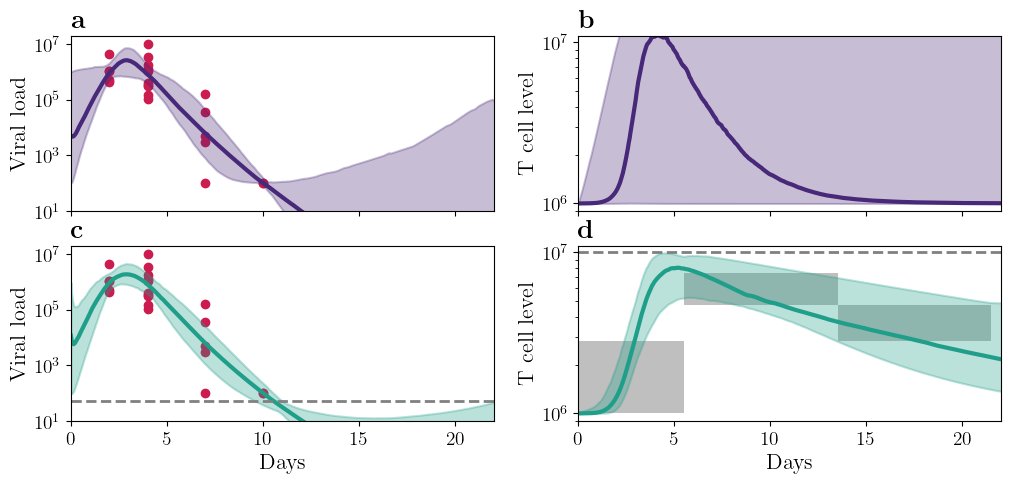

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,5), sharex=True)

axs[0,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette_2[1], marker="o")
axs[0,0].plot(t, median_VQt, lw=3, color=palette[0])
axs[0,0].fill_between(t, confidence_VQt[0], confidence_VQt[1], color=palette[0], alpha=0.3, lw=1.5)
axs[0,0].set_yscale('log')
axs[0,0].set_xlim((0, 22))
axs[0,0].set_ylim((1e1, 2e7))

axs[0,1].plot(t, median_TQt, lw=3, color=palette[0])
axs[0,1].fill_between(t, confidence_TQt[0], confidence_TQt[1], color=palette[0], alpha=0.3, lw=1.5)
axs[0,1].set_yscale('log')
axs[0,1].set_xlim((0, 22))
axs[0,1].set_ylim((0.9e6, 1.1e7))

for i in range(len(dfTcellQual['tmin'])):
    tmin = dfTcellQual['tmin'].values[i]
    Tmin = dfTcellQual['Tmin'].values[i]
    width = dfTcellQual['tmax'].values[i] - tmin
    height = dfTcellQual['Tmax'].values[i] - Tmin
    rect = plt.Rectangle((tmin, Tmin), width, height, fc='gray', alpha=0.5)
    axs[1,1].add_patch(rect)

axs[1,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette_2[1], marker="o")
axs[1,0].plot(t, median_VQl, lw=3, color=palette[4])
axs[1,0].fill_between(t, confidence_VQl[0], confidence_VQl[1], color=palette[4], alpha=0.3, lw=1.5)
axs[1,0].hlines(y = 5e1, xmin=0, xmax=25, color='gray', lw=2, ls='--')
axs[1,0].set_yscale('log')
axs[1,0].set_xlim((0, 22))
axs[1,0].set_ylim((1e1, 2e7))

axs[1,1].plot(t, median_TQl, lw=3, color=palette[4])
axs[1,1].fill_between(t, confidence_TQl[0], confidence_TQl[1], color=palette[4], alpha=0.3, lw=1.5)
axs[1,1].hlines(y = 1e7, xmin=0, xmax=25, color='gray', lw=2, ls='--')
axs[1,1].set_yscale('log')
axs[1,1].set_xlim((0, 22))
axs[1,1].set_ylim((0.9e6, 1.1e7))

axs[0,0].set_ylabel('Viral load')
axs[0,0].set_title(r'\textbf{a}', loc='left')

axs[0,1].set_ylabel('T cell level')
axs[0,1].set_title(r'\textbf{b}', loc='left')

axs[1,0].set_ylabel('Viral load')
axs[1,0].set_title(r'\textbf{c}', loc='left')

axs[1,1].set_ylabel('T cell level')
axs[1,1].set_title(r'\textbf{d}', loc='left')

axs[1,0].set_xlabel('Days')
axs[1,1].set_xlabel('Days')

# plt.savefig("influenza_graphs.svg", transparent=True)

plt.show()

### Parameter distribution

In [22]:
dfParams_quant['Strategy'] = 'I'
dfParams_qual['Strategy'] = 'II'
dfParams_all = pd.concat([dfParams_quant, dfParams_qual])
# dfParams_all = dfParams_quant.copy()

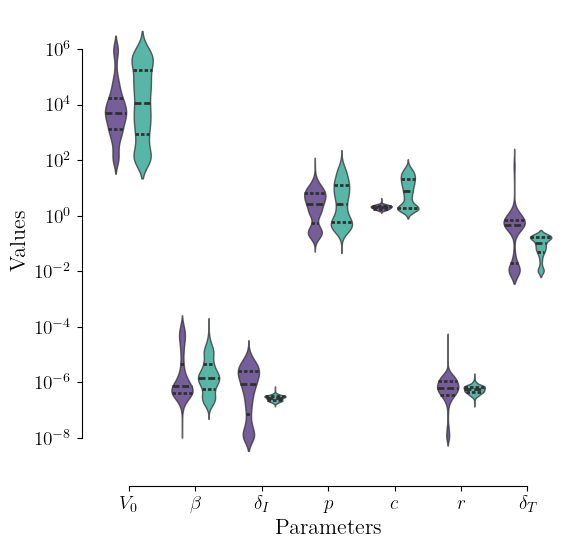

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6), facecolor='white')

colors = [palette[0], palette[4]]

axs = sns.violinplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategy', log_scale=True,
               palette=colors, alpha=0.75, linewidth=1.0, density_norm="count", gap=0.2,
               inner="quart", saturation=1, inner_kws=dict(linewidth=2))

sns.despine(offset=10, trim=True);

plt.legend([],[], frameon=False)

# plt.savefig("influenza_boots.svg", transparent=True)

plt.show()

### Likelihood profiles

In [24]:
df_V0_qt = pd.read_csv('influenza/profilesData/V0_profile_qt.dat', sep=' ', names=parNames).filter(['$V_0$', 'RSS'])
df_bet_qt = pd.read_csv('influenza/profilesData/beta_profile_qt.dat', sep=' ', names=parNames).filter(['$\\beta$', 'RSS'])
df_delI_qt = pd.read_csv('influenza/profilesData/delI_profile_qt.dat', sep=' ', names=parNames).filter(['$\\delta_I$', 'RSS'])
df_p_qt = pd.read_csv('influenza/profilesData/p_profile_qt.dat', sep=' ', names=parNames).filter(['$p$', 'RSS'])
df_c_qt = pd.read_csv('influenza/profilesData/c_profile_qt.dat', sep=' ', names=parNames).filter(['$c$', 'RSS'])
df_r_qt = pd.read_csv('influenza/profilesData/r_profile_qt.dat', sep=' ', names=parNames).filter(['$r$', 'RSS'])
df_delT_qt = pd.read_csv('influenza/profilesData/delT_profile_qt.dat', sep=' ', names=parNames).filter(['$\\delta_T$', 'RSS'])

In [25]:
df_V0_ql = pd.read_csv('influenza/profilesData/V0_profile_ql.dat', sep=' ', names=parNames).filter(['$V_0$', 'RSS'])
df_bet_ql = pd.read_csv('influenza/profilesData/beta_profile_ql.dat', sep=' ', names=parNames).filter(['$\\beta$', 'RSS'])
df_delI_ql = pd.read_csv('influenza/profilesData/delI_profile_ql.dat', sep=' ', names=parNames).filter(['$\\delta_I$', 'RSS'])
df_p_ql = pd.read_csv('influenza/profilesData/p_profile_ql.dat', sep=' ', names=parNames).filter(['$p$', 'RSS'])
df_c_ql = pd.read_csv('influenza/profilesData/c_profile_ql.dat', sep=' ', names=parNames).filter(['$c$', 'RSS'])
df_r_ql = pd.read_csv('influenza/profilesData/r_profile_ql.dat', sep=' ', names=parNames).filter(['$r$', 'RSS'])
df_delT_ql = pd.read_csv('influenza/profilesData/delT_profile_ql.dat', sep=' ', names=parNames).filter(['$\\delta_T$', 'RSS'])

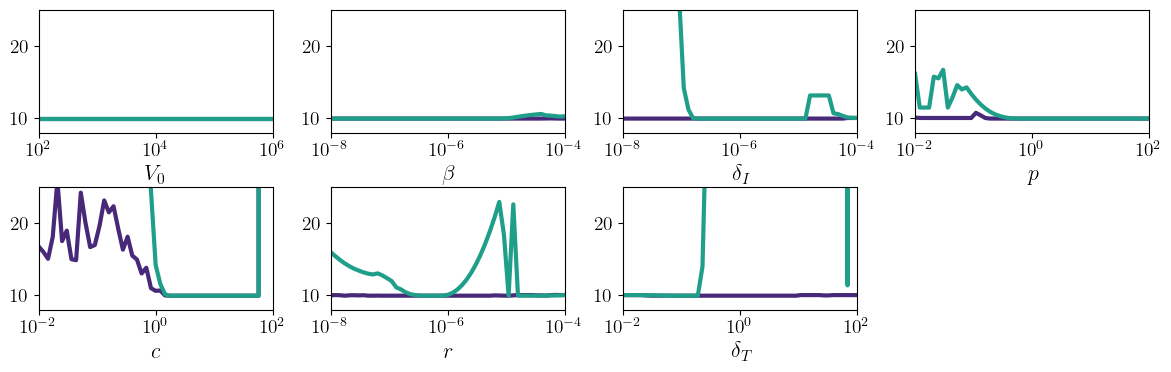

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,4), facecolor='white')

axs[0,0].plot(10**df_V0_qt['$V_0$'], df_V0_qt['RSS'], lw=3, color=palette[0])
axs[0,0].plot(10**df_V0_ql['$V_0$'], df_V0_ql['RSS'], lw=3, color=palette[4])
axs[0,0].set_xlabel('$V_0$')
# axs[0,0].set_ylabel('RSS')
axs[0,0].set_xlim((1e2,1e6))

axs[0,1].plot(10**df_bet_qt['$\\beta$'], df_bet_qt['RSS'], lw=3, color=palette[0])
axs[0,1].plot(10**df_bet_ql['$\\beta$'], df_bet_ql['RSS'], lw=3, color=palette[4])
axs[0,1].set_xlabel('$\\beta$')
# axs[0,1].set_ylabel('RSS')
axs[0,1].set_xlim((1e-8,1e-4))

axs[0,2].plot(10**df_delI_qt['$\\delta_I$'], df_delI_qt['RSS'], lw=3, color=palette[0])
axs[0,2].plot(10**df_delI_ql['$\\delta_I$'], df_delI_ql['RSS'], lw=3, color=palette[4])
axs[0,2].set_xlabel('$\\delta_I$')
# axs[0,2].set_ylabel('RSS')
axs[0,2].set_xlim((1e-8,1e-4))

axs[0,3].plot(10**df_p_qt['$p$'], df_p_qt['RSS'], lw=3, color=palette[0])
axs[0,3].plot(10**df_p_ql['$p$'], df_p_ql['RSS'], lw=3, color=palette[4])
axs[0,3].set_xlabel('$p$')
# axs[0,3].set_ylabel('RSS')
axs[0,3].set_xlim((1e-2,1e2))

axs[1,0].plot(10**df_c_qt['$c$'], df_c_qt['RSS'], lw=3, color=palette[0])
axs[1,0].plot(10**df_c_ql['$c$'], df_c_ql['RSS'], lw=3, color=palette[4])
axs[1,0].set_xlabel('$c$')
# axs[1,0].set_ylabel('RSS')
axs[1,0].set_xlim((1e-2,1e2))

axs[1,1].plot(10**df_r_qt['$r$'], df_r_qt['RSS'], lw=3, color=palette[0])
axs[1,1].plot(10**df_r_ql['$r$'], df_r_ql['RSS'], lw=3, color=palette[4])
axs[1,1].set_xlabel('$r$')
# axs[1,1].set_ylabel('RSS')
axs[1,1].set_xlim((1e-8,1e-4))

axs[1,2].plot(10**df_delT_qt['$\\delta_T$'], df_delT_qt['RSS'], lw=3, color=palette[0])
axs[1,2].plot(10**df_delT_ql['$\\delta_T$'], df_delT_ql['RSS'], lw=3, color=palette[4])
axs[1,2].set_xlabel('$\\delta_T$')
# axs[1,2].set_ylabel('RSS')
axs[1,2].set_xlim((1e-2,1e2))

for i in range(2):
    for j in range(4):
        axs[i,j].set_xscale('log')
plt.setp(axs, ylim=(8,25))

plt.tight_layout(w_pad=0.5, h_pad=0.1)

fig.delaxes(axs[1,3])

# plt.savefig("influenza_profiles.svg")

plt.show()

## Estimating parameter with three parameters fixed

In [27]:
def apply_exponent(value):
    return 10 ** value

### Quantitative estimation

In [28]:
dfParams_log = pd.read_csv('influenza/bestPars_quant_fix.dat', sep=' ', names=parNames)

In [29]:
dfParams = dfParams_log.apply(lambda x: apply_exponent(x) if x.name != 'RSS' else x)

In [30]:
dfParams.head()

,$V_0$,$\beta$,$\delta_I$,$p$,$c$,$r$,$\delta_T$,RSS
0,50.003453,1.909414e-05,1.000000e-08,0.311387,2.900013,1.468250e-06,0.011,6.2676
1,50.003453,1.047129e-05,9.264031e-08,0.467412,2.900013,8.493760e-07,0.011,9.9461
2,50.003453,1.347411e-05,1.118922e-07,0.393641,2.900013,9.536741e-07,0.011,5.6049
3,50.003453,2.127159e-06,1.853105e-06,2.588213,2.900013,1.000000e-08,0.011,12.5240
4,50.003453,8.568405e-07,1.498649e-06,7.350214,2.900013,1.000000e-08,0.011,5.6863


In [31]:
dfParam_describe_qt = dfParams.drop(['$V_0$', '$c$', '$\\delta_T$', 'RSS'], axis=1)
dfParam_describe_qt.describe()

,$\beta$,$\delta_I$,$p$,$r$
count,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03
mean,1.573778e-05,1.039873e-06,1.645948,3.576588e-07
std,2.820879e-05,6.806176e-07,1.173283,5.639863e-07
min,5.317408e-07,1.000000e-08,0.147979,1.000000e-08
25%,2.542144e-06,1.360508e-07,0.551350,1.000000e-08
50%,3.869015e-06,1.465548e-06,1.560271,1.000000e-08
75%,1.117463e-05,1.555607e-06,2.330908,6.682321e-07
max,1.000000e-04,1.896269e-06,8.910457,2.889349e-06


In [32]:
dfParam_describe_qt.median()

$\beta$       3.869015e-06
$\delta_I$    1.465548e-06
$p$           1.560271e+00
$r$           1.000000e-08
dtype: float64

In [33]:
np.percentile(dfParam_describe_qt, [2.5, 97.5], axis=0)

array([[1.41629419e-06, 1.00000000e-08, 2.34820057e-01, 1.00000000e-08],
       [1.00000000e-04, 1.71437175e-06, 4.20823515e+00, 1.80198061e-06]])

In [34]:
U0 = 1e7
I0 = 0
V0 = 0
T0 = 1e6
Y0 = [U0, I0, V0, T0]

t = np.linspace(0, 25, 561)

simNumber = dfParams.shape[0]

U_Qt, I_Qt, V_Qt, T_Qt = simulations(dfParams, Y0, t, simNumber)

In [35]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
VQt_2D = np.array(V_Qt)
TQt_2D = np.array(T_Qt)
median_VQt = np.median(VQt_2D, axis=0)
confidence_VQt = np.percentile(VQt_2D, [2.5, 97.5], axis=0)
median_TQt = np.median(TQt_2D, axis=0)
confidence_TQt = np.percentile(TQt_2D, [2.5, 97.5], axis=0)
# mean_VQt = np.mean(VQt_2D, axis=0)
# std_VQt = np.std(VQt_2D, axis=0)

In [36]:
dfParams_quant = dfParams.drop(columns=['$V_0$', '$c$', '$\\delta_T$', 'RSS']).melt(var_name='Parameters', value_name='Values')

### Qualitative T cell level

In [37]:
dfParams_log = pd.read_csv('influenza/bestPars_qual_fix.dat', sep=' ', names=parNames)

In [38]:
dfParams = dfParams_log.apply(lambda x: apply_exponent(x) if x.name != 'RSS' else x)

In [39]:
dfParams.tail(4)

,$V_0$,$\beta$,$\delta_I$,$p$,$c$,$r$,$\delta_T$,RSS
996,50.003453,0.000007,3.571083e-07,0.746449,2.900013,4.468893e-07,0.011,8.5867
997,50.003453,0.000008,3.698282e-07,0.836373,2.900013,4.103931e-07,0.011,11.5250
998,50.003453,0.000004,4.177342e-07,1.041358,2.900013,3.663532e-07,0.011,16.3470
999,50.003453,0.000010,3.293063e-07,0.550174,2.900013,5.663697e-07,0.011,6.4180


In [40]:
dfParam_describe_ql = dfParams.drop(['$V_0$', '$c$', '$\\delta_T$', 'RSS'], axis=1)
dfParam_describe_ql.describe()

,$\beta$,$\delta_I$,$p$,$r$
count,1000.000000,1.000000e+03,1000.000000,1.000000e+03
mean,0.000009,3.409495e-07,0.803928,4.593809e-07
std,0.000008,4.313452e-08,0.305108,1.435112e-07
min,0.000002,2.373012e-07,0.208161,1.535324e-07
25%,0.000006,3.057560e-07,0.589658,3.495023e-07
50%,0.000008,3.481369e-07,0.739691,4.437108e-07
75%,0.000010,3.720703e-07,0.954388,5.410346e-07
max,0.000100,4.479195e-07,2.399385,1.356438e-06


In [41]:
dfParam_describe_ql.median()

$\beta$       7.625201e-06
$\delta_I$    3.481369e-07
$p$           7.396908e-01
$r$           4.437108e-07
dtype: float64

In [42]:
np.percentile(dfParam_describe_ql, [2.5, 97.5], axis=0)

array([[3.21882600e-06, 2.58693198e-07, 3.97756976e-01, 2.25128366e-07],
       [2.00415954e-05, 4.17359213e-07, 1.57094204e+00, 7.65193556e-07]])

In [43]:
U0 = 1e7
I0 = 0
V0 = 0
T0 = 1e6
Y0 = [U0, I0, V0, T0]

t = np.linspace(0, 25, 561)

simNumber = dfParams.shape[0]

U_Ql, I_Ql, V_Ql, T_Ql = simulations(dfParams, Y0, t, simNumber)

In [44]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
VQl_2D = np.array(V_Ql)
TQl_2D = np.array(T_Ql)
median_VQl = np.median(VQl_2D, axis=0)
confidence_VQl = np.percentile(VQl_2D, [2.5, 97.5], axis=0)
median_TQl = np.median(TQl_2D, axis=0)
confidence_TQl = np.percentile(TQl_2D, [2.5, 97.5], axis=0)
# mean_VQl = np.mean(VQl_2D, axis=0)
# std_VQl = np.std(VQl_2D, axis=0)

In [45]:
dfParams_qual = dfParams.drop(columns=['$V_0$', '$c$', '$\\delta_T$', 'RSS']).melt(var_name='Parameters', value_name='Values')

### Simulation plots

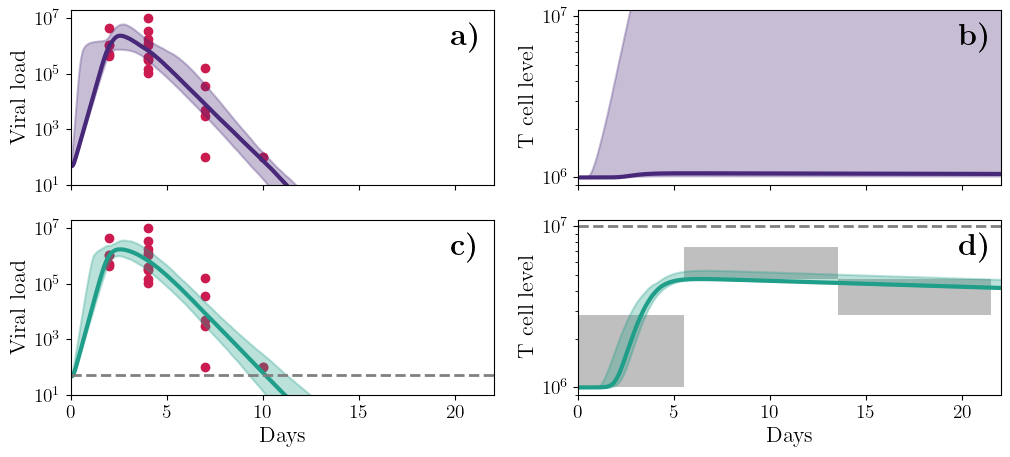

In [60]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,5), sharex=True)

axs[0,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette_2[1], marker="o")
axs[0,0].plot(t, median_VQt, lw=3, color=palette[0])
axs[0,0].fill_between(t, confidence_VQt[0], confidence_VQt[1], color=palette[0], alpha=0.3, lw=1.5)
axs[0,0].set_yscale('log')
axs[0,0].set_xlim((0, 22))
axs[0,0].set_ylim((1e1, 2e7))

axs[0,1].plot(t, median_TQt, lw=3, color=palette[0])
axs[0,1].fill_between(t, confidence_TQt[0], confidence_TQt[1], color=palette[0], alpha=0.3, lw=1.5)
axs[0,1].set_yscale('log')
axs[0,1].set_xlim((0, 22))
axs[0,1].set_ylim((0.9e6, 1.1e7))

for i in range(len(dfTcellQual['tmin'])):
    tmin = dfTcellQual['tmin'].values[i]
    Tmin = dfTcellQual['Tmin'].values[i]
    width = dfTcellQual['tmax'].values[i] - tmin
    height = dfTcellQual['Tmax'].values[i] - Tmin
    rect = plt.Rectangle((tmin, Tmin), width, height, fc='gray', alpha=0.5)
    axs[1,1].add_patch(rect)

axs[1,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette_2[1], marker="o")
axs[1,0].plot(t, median_VQl, lw=3, color=palette[4])
axs[1,0].fill_between(t, confidence_VQl[0], confidence_VQl[1], color=palette[4], alpha=0.3, lw=1.5)
axs[1,0].hlines(y = 5e1, xmin=0, xmax=25, color='gray', lw=2, ls='--')
axs[1,0].set_yscale('log')
axs[1,0].set_xlim((0, 22))
axs[1,0].set_ylim((1e1, 2e7))

axs[1,1].plot(t, median_TQl, lw=3, color=palette[4])
axs[1,1].fill_between(t, confidence_TQl[0], confidence_TQl[1], color=palette[4], alpha=0.3, lw=1.5)
axs[1,1].hlines(y = 1e7, xmin=0, xmax=25, color='gray', lw=2, ls='--')
axs[1,1].set_yscale('log')
axs[1,1].set_xlim((0, 22))
axs[1,1].set_ylim((0.9e6, 1.1e7))

axs[0,0].set_ylabel('Viral load')
axs[0,1].set_ylabel('T cell level')
axs[1,0].set_ylabel('Viral load')
axs[1,1].set_ylabel('T cell level')

axs[0,0].text(0.9, 0.93, r'\textbf{a)}', transform=axs[0,0].transAxes, fontsize=22, va='top', ha='left')
axs[0,1].text(0.9, 0.93, r'\textbf{b)}', transform=axs[0,1].transAxes, fontsize=22, va='top', ha='left')
axs[1,0].text(0.9, 0.93, r'\textbf{c)}', transform=axs[1,0].transAxes, fontsize=22, va='top', ha='left')
axs[1,1].text(0.9, 0.93, r'\textbf{d)}', transform=axs[1,1].transAxes, fontsize=22, va='top', ha='left')

axs[1,0].set_xlabel('Days')
axs[1,1].set_xlabel('Days')

# plt.savefig("influenza_graphs_fix.svg", transparent=True)

plt.show()

### Parameter distribution

In [61]:
dfParams_quant['Strategy'] = 'I'
dfParams_qual['Strategy'] = 'II'
dfParams_all = pd.concat([dfParams_quant, dfParams_qual])
# dfParams_all = dfParams_quant.copy()

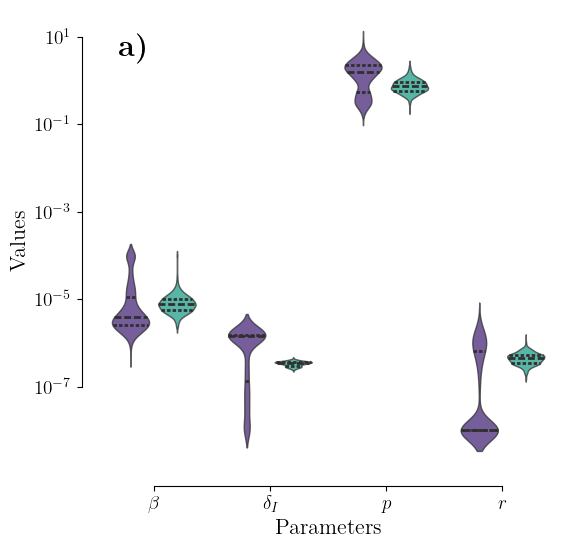

In [68]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6), facecolor='white')

colors = [palette[0], palette[4]]

axs = sns.violinplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategy', log_scale=True,
               palette=colors, alpha=0.75, linewidth=1.0, density_norm="count", gap=0.2,
               inner="quart", saturation=1, inner_kws=dict(linewidth=2))

sns.despine(offset=10, trim=True);

axs.text(0.05, 0.95, r'\textbf{a)}', transform=axs.transAxes, fontsize=22, va='top', ha='left')

plt.legend([],[], frameon=False)

# plt.savefig("influenza_boots_fix.svg", transparent=True)

plt.show()

In [69]:
dirPath = 'influenza/profilesData_fix/'

In [70]:
df_bet_qt = pd.read_csv(dirPath+'beta_profile_qt.dat', sep=' ', names=parNames).filter(['$\\beta$', 'RSS'])
df_delI_qt = pd.read_csv(dirPath+'delI_profile_qt.dat', sep=' ', names=parNames).filter(['$\\delta_I$', 'RSS'])
df_p_qt = pd.read_csv(dirPath+'p_profile_qt.dat', sep=' ', names=parNames).filter(['$p$', 'RSS'])
df_r_qt = pd.read_csv(dirPath+'r_profile_qt.dat', sep=' ', names=parNames).filter(['$r$', 'RSS'])

In [71]:
df_bet_ql = pd.read_csv(dirPath+'beta_profile_ql.dat', sep=' ', names=parNames).filter(['$\\beta$', 'RSS'])
df_delI_ql = pd.read_csv(dirPath+'delI_profile_ql.dat', sep=' ', names=parNames).filter(['$\\delta_I$', 'RSS'])
df_p_ql = pd.read_csv(dirPath+'p_profile_ql.dat', sep=' ', names=parNames).filter(['$p$', 'RSS'])
df_r_ql = pd.read_csv(dirPath+'r_profile_ql.dat', sep=' ', names=parNames).filter(['$r$', 'RSS'])

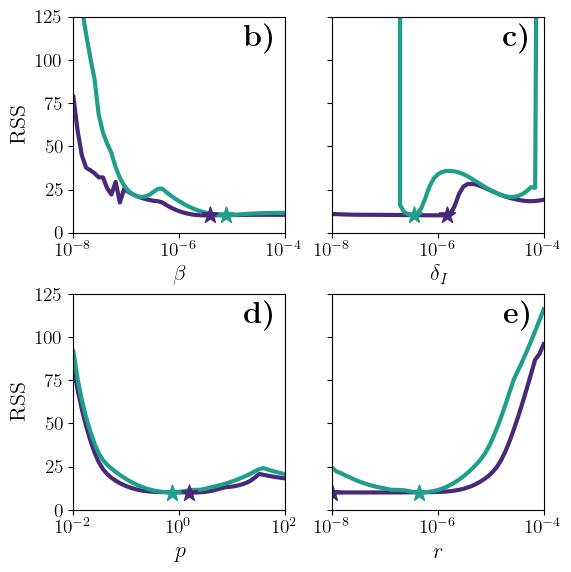

In [92]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), facecolor='white', sharey=True)

axs[0,0].plot(10**df_bet_qt['$\\beta$'], df_bet_qt['RSS'], lw=3, color=palette[0])
axs[0,0].plot(10**df_bet_ql['$\\beta$'], df_bet_ql['RSS'], lw=3, color=palette[4])
axs[0,0].scatter(dfParam_describe_qt.median()['$\\beta$'], 10, color=palette[0],
                 marker='*', s=150, zorder=2)
axs[0,0].scatter(dfParam_describe_ql.median()['$\\beta$'], 10, color=palette[4],
                 marker='*', s=150, zorder=2)
# axs[0,0].set_xscale('log')
axs[0,0].set_xlabel('$\\beta$')
axs[0,0].set_ylabel('RSS')
axs[0,0].set_xlim((1e-8,1e-4))

axs[0,1].plot(10**df_delI_qt['$\\delta_I$'], df_delI_qt['RSS'], lw=3, color=palette[0])
axs[0,1].plot(10**df_delI_ql['$\\delta_I$'], df_delI_ql['RSS'], lw=3, color=palette[4])
axs[0,1].scatter(dfParam_describe_qt.median()['$\\delta_I$'], 10, color=palette[0],
                 marker='*', s=150, zorder=2)
axs[0,1].scatter(dfParam_describe_ql.median()['$\\delta_I$'], 10, color=palette[4],
                 marker='*', s=150, zorder=2)
axs[0,1].set_xlabel('$\\delta_I$')
axs[0,1].set_xlim((1e-8,1e-4))

axs[1,0].plot(10**df_p_qt['$p$'], df_p_qt['RSS'], lw=3, color=palette[0])
axs[1,0].plot(10**df_p_ql['$p$'], df_p_ql['RSS'], lw=3, color=palette[4])
axs[1,0].scatter(dfParam_describe_qt.median()['$p$'], 10, color=palette[0],
                 marker='*', s=150, zorder=2)
axs[1,0].scatter(dfParam_describe_ql.median()['$p$'], 10, color=palette[4],
                 marker='*', s=150, zorder=2)
axs[1,0].set_xlabel('$p$')
axs[1,0].set_ylabel('RSS')
axs[1,0].set_xlim((1e-2,1e2))

axs[1,1].plot(10**df_r_qt['$r$'], df_r_qt['RSS'], lw=3, color=palette[0])
axs[1,1].plot(10**df_r_ql['$r$'], df_r_ql['RSS'], lw=3, color=palette[4])
axs[1,1].scatter(dfParam_describe_qt.median()['$r$'], 10, color=palette[0],
                 marker='*', s=150, zorder=2)
axs[1,1].scatter(dfParam_describe_ql.median()['$r$'], 10, color=palette[4],
                 marker='*', s=150, zorder=2)
axs[1,1].set_xlabel('$r$')
axs[1,1].set_xlim((1e-8,1e-4))

for i in range(2):
    for j in range(2):
        axs[i,j].set_xscale('log')
plt.setp(axs, ylim=(0,125))

axs[0,0].text(0.81, 0.97, r'\textbf{b)}', transform=axs[0,0].transAxes, fontsize=22, va='top', ha='left')
axs[0,1].text(0.81, 0.97, r'\textbf{c)}', transform=axs[0,1].transAxes, fontsize=22, va='top', ha='left')
axs[1,0].text(0.81, 0.97, r'\textbf{d)}', transform=axs[1,0].transAxes, fontsize=22, va='top', ha='left')
axs[1,1].text(0.81, 0.97, r'\textbf{e)}', transform=axs[1,1].transAxes, fontsize=22, va='top', ha='left')

plt.tight_layout(w_pad=0.5, h_pad=0.1)
# plt.savefig("influenza_profiles_fix.svg", transparent=True)

plt.show()